# Binary Classification

In [1]:
import toml
import pandas as pd

from app.cleaning import LabelCleaner, ImageCleaner
from app.imaging import ImageHandler
from app.model import ModelController, ModelParameters, ModelPreparation, ModelPredictor
from app.utils import load_model
from app.plotter import plot_cm, plot_losses, plot_model_preds

In [2]:
all_params = toml.load("parameters.toml")

label_params = all_params['labelparameters']
model_params_dict = {key.lower(): val for key, val in all_params['modelparameters'].items()}
dataset_filenames_dict = all_params['dataset_filenames']

In [3]:
print(label_params)
print(model_params_dict)
print(dataset_filenames_dict)

{'LABEL_CLASSES': ['civilian', 'military'], 'LABEL_COLUMNS': ['filename', 'class', 'type']}
{'epochs': 1000, 'learning_rate': 0.001, 'batch_size': 128, 'hidden_layer_sizes': [512, 256], 'num_classes': 2, 'seed': 386}
{'train_labels': 'train_labels.csv', 'test_labels': 'test_labels.csv'}


## Label Pre-Processing

In [4]:
cleaner = LabelCleaner(dataset_filenames_dict)
all_labels = cleaner.update(label_params['LABEL_CLASSES'])

Total records: 11436
Multi-labelled items removed: 75
Duplicates removed: 4686
Data without labels removed: 3
Total records after cleaning: 6672


In [5]:
all_labels

,img_filepaths,filename,class,type
0,C:\Projects\Rowden\data\000_14M0LD-e1525732547...,000_14M0LD-e1525732547750-400x250.jpg,military,test
1,C:\Projects\Rowden\data\000_1H95VB.width-800.jpg,000_1H95VB.width-800.jpg,military,test
2,C:\Projects\Rowden\data\000_1LC27X-e1570900274...,000_1LC27X-e1570900274807-1024x640.jpg,military,test
3,C:\Projects\Rowden\data\0023ae82ca0f1487c33a46...,0023ae82ca0f1487c33a46.jpg,civilian,train
4,C:\Projects\Rowden\data\01-BOAC-Comet-1-G-BOAC...,01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...,civilian,test
...,...,...,...,...
6667,C:\Projects\Rowden\data\_110072566_gettyimages...,_110072566_gettyimages-1134568783.jpg,military,test
6668,C:\Projects\Rowden\data\_57608873_drone.jpg,_57608873_drone.jpg,military,test
6669,C:\Projects\Rowden\data\_83539969_b47a9225-6db...,_83539969_b47a9225-6db2-4f83-975d-576edf0279e6...,military,test
6670,C:\Projects\Rowden\data\_90482169_a1648047-7a1...,_90482169_a1648047-7a18-441a-923c-c44260e5b19e...,military,test


## Update Image Names & Location

In [7]:
img_handler = ImageHandler(data_labels, class_labels=label_params['LABEL_CLASSES'])

In [8]:
img_handler.update_data_dir()

Data directory has been organised! No updates required.


In [9]:
data_labels = img_handler.data_labels
data_labels

,filename,class,type,img_filepaths
0,military_0.jpg,military,train,C:\Projects\Rowden\data\010205-F-1631A-001.jpg
1,military_1.jpg,military,train,C:\Projects\Rowden\data\020307-N-5067K-001.jpg
2,military_2.jpg,military,train,C:\Projects\Rowden\data\022713tank_960x540.jpg
3,military_3.jpg,military,train,C:\Projects\Rowden\data\03d_on12_bell47gfranks...
4,military_4.jpg,military,train,C:\Projects\Rowden\data\03helicopters2-span-ar...
...,...,...,...,...
6620,civilian_1951.jpg,civilian,test,C:\Projects\Rowden\data\images85(10).jpg
6621,civilian_1952.jpg,civilian,test,C:\Projects\Rowden\data\images85(11).jpg
6622,civilian_1953.jpg,civilian,test,C:\Projects\Rowden\data\images85(8).jpg
6623,civilian_1954.jpg,civilian,test,C:\Projects\Rowden\data\images85(9).jpg


In [10]:
train_indices = data_labels[data_labels['type'] == 'train'].index.to_list()
test_indices = data_labels[data_labels['type'] == 'test'].index.to_list()

In [11]:
model_params = ModelParameters(**model_params_dict)
model_prep = ModelPreparation(model_params)

In [12]:
train_loader, valid_loader, test_loader = model_prep.split_data(
    data_filepath='data',
    train_indices=train_indices,
    test_indices=test_indices
)

Training data: 5645
Validation data: 490
Test data: 490


## Create & Train Model

In [13]:
model_controller = ModelController(model_params=model_params, train_loader=train_loader, valid_loader=valid_loader)

In [14]:
model = model_controller.train(epochs=model_params.epochs, save_filepath='saved_models/mobilenetv3.pt')

## Load Model & Visualise Results

In [15]:
model_params = ModelParameters(**model_params_dict)
model = load_model(model_controller.model, filepath='saved_models/mobilenetv3.pt')

In [16]:
model_predictor = ModelPredictor(model, test_data=test_loader)

In [17]:
y_pred, y_true = model_predictor.predict(seed=model_params.seed)

In [18]:
stats = model_predictor.compute_stats(y_pred, y_true)
stats

{'precision': 0.796875,
 'recall': 0.796875,
 'accuracy': 0.796875,
 'f1_score': 0.796875}

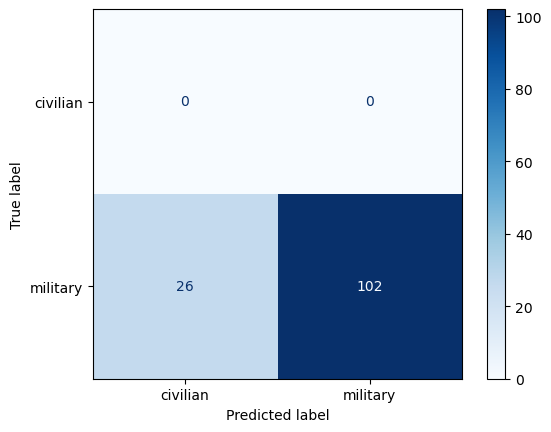

In [19]:
# | TP | FP |
# | FN | TN |
plot_cm(y_pred, y_true, label_params['LABEL_CLASSES'])

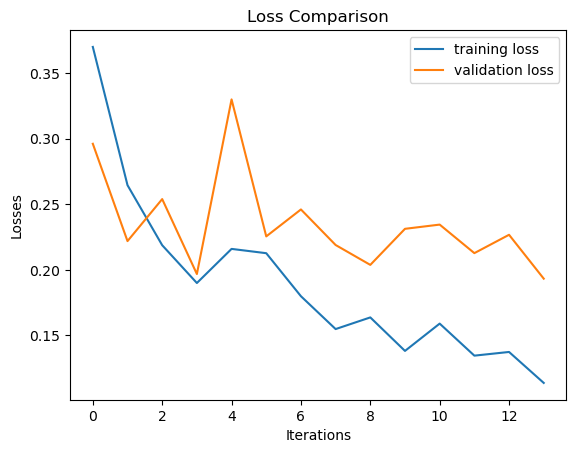

In [20]:
plot_losses(model.logger.train_loss, model.logger.valid_loss)

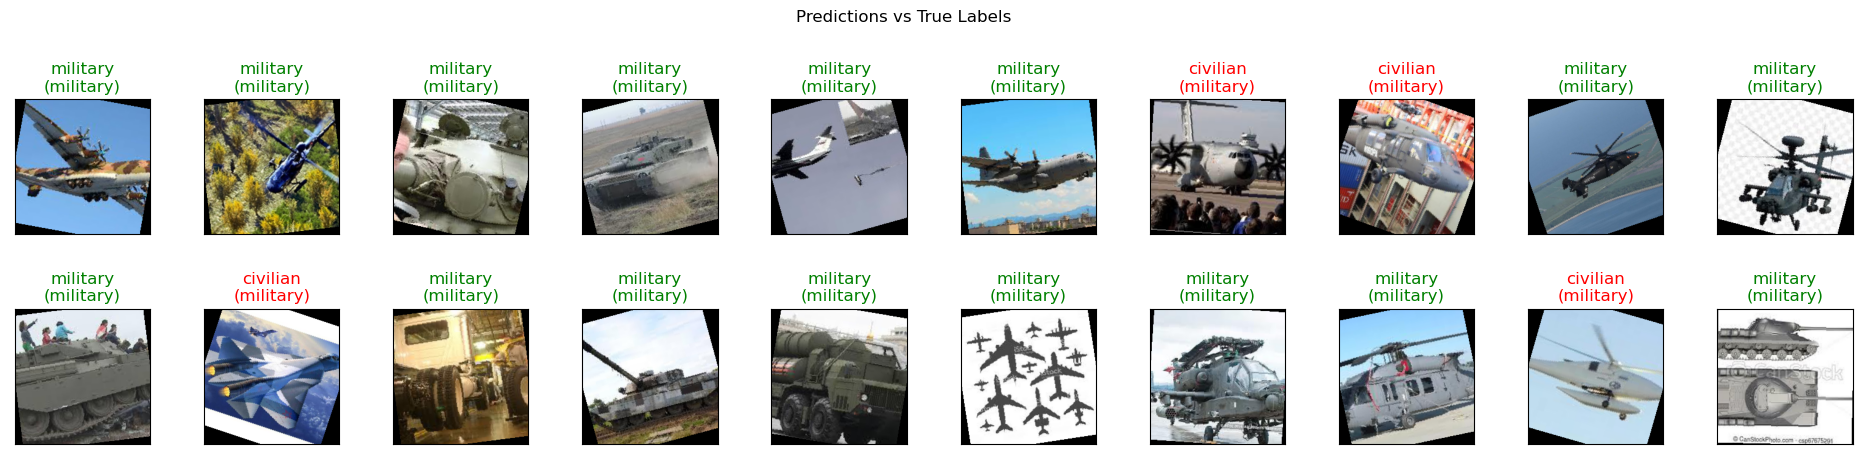

In [21]:
plot_model_preds(model, test_data=test_loader, class_labels=label_params['LABEL_CLASSES'])